In [1]:
import osmnx as ox, networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import geopandas as gpd
import functools
import time
%matplotlib inline

pd.set_option('precision', 5)
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None

In [2]:
import street_network_functions as snf
import utilities as uf

In [239]:
reload(uf)

<module 'utilities' from 'C:\\Users\\g_filo01\\sciebo\\scripts\\Image of the City\\utilities.py'>

In [6]:
#initialise path, names, etc.

city_name = 'London'
folder_ouptut ='Outputs/'+city_name+'/'
epsg = 27700
crs = {'init': 'epsg:27700', 'no_defs': True}

# city_name = 'Boston'
# folder_output ='Outputs/'+city_name+'/'
# epsg = 26986
# crs = {'init': 'epsg:26986', 'no_defs': True}

# Downloading the data by place or Loading shapefile

1 or 2 street networks (SN) may be needed when the case study is a particular urban area (UA).

### Method 1 ------------
Only one graph is used (*graph_A*): It includes the SN of UA and its surroundings (e.g. buffer of 2000 mt) and it is used for computing centrality measures as well as for districts identification. Paths, nodes and districts are extracted from *graph_A* by clipping them from the polygon representing UA extension. A large network is empolyed so as to prevent the edge-effect when computing centrality measures.

### Method 2 ------------
Two graphs are used: *graph_A* as above, plus a second one, *graph_B* even more extended than the first, for a more precise districts extraction. Paths and nodes are extracted from *graph_A*, districts from *graph_B*, by clipping them from the polygon representing UA extension.

In [152]:
# choose the method and specify how the graph is obtained

method_1 = True
method_2 = False

download = True
shapeFiles = False

In [38]:
# loading data

if (city_name == 'Boston'):
    directory_polygon = 'C:/Users/g_filo01/sciebo/GIS Data/Boston/city_center.shp'
    directory_graph_A = 'C:/Users/g_filo01/sciebo/GIS Data/Boston/Street_Network/boston_sn_26986_clipped_4000.shp'  
    directory_graph_B = 'C:/Users/g_filo01/sciebo/GIS Data/Boston/Street_Network/boston_sn_26986_clipped_8000_noHW.shp'
    
elif (city_name == 'London'):
    directory_polygon = 'C:/Users/g_filo01/sciebo/GIS Data/London/Congestion_area_polygon/Polygon.shp'

In [6]:
# provide files' directories

if (shapeFiles == True):
    
    if (option_1 == True):
        nodes_small, edges_small = snf.get_fromSHP(directory_graphA, epsg, crs, area = None)
        polygon_clip = gpd.read_file(directory_polygon)
    
    elif (option_2 == True):
        nodes_small, edges_small =  snf.get_fromSHP(directory_graphA, epsg, crs, simplify = True, area = None)
        nodes_small, edges_small =  snf.get_fromSHP(directory_graphB, epsg, crs, simplify = True, area = None)
        polygon_clip = gpd.read_file(directory_polygon)

Choose between the following methods:
* *OSMplace*, provide an OSM place name (e.g. City).
* *OSMpolygon*, provide an OSM polygon (relation) name.
* *distance_from_address*, provide a precise address.
* *shapefilePolygon*, provide directory of a .shp file of the area.

In [471]:
if (download == True):
    
    if (option_1 == True):
        #graph_A  
        method_A = 'distance_from_address' 
        place_A = 'Temple Place, London, UK'
        nodes_small, edges_small = snf.get_fromOSM(method_A, place_A, 'walk', epsg, distance = 4000)
        polygon_clip = gpd.read_file(directory_polygon)
        print("done - Option 1")
        
    
    elif (option_2 == True):      
        #graph_A
        method_A = 'distance_from_address' 
        place_A = 'Temple Place, London, UK'
        nodes_small, edges_small = snf.get_fromOSM(method_A, place_A, 'walk', epsg, distance = 4000)
        
        # graph_B
        method_B = 'shapefilePolygon' 
        place_B = 'Greater London (175342)'
        nodes_large, edges_large = snf.get_fromOSM(method_B, place_B, 'walk', epsg)
        
        print("done - Option 2")

done - Option 1


# Cleaning and simplyfing the Street Network - gdf

At the end of the previous section two files are obtained: nodes and edges (vertexes, or links). Below, before creating the actual graph, the two datasets are cleaned, simplified and corrected.

Cleaning functions handle:
* Duplicate geometries (nodes, edges).
* Pseudo-nodes.
* Dead-ends (optional).

Simplyfing functions handle (*in progress*):
* Roundabouts detection and merging.
* Dual-lane collapsing.
* Complex junctions with ramps and multiple access simplification.

In [472]:
%%time
nodes_small, edges_small = snf.reset_index_gdf(nodes_small, edges_small)
nodes_small, edges_small = snf.simplify_network(nodes_small, edges_small, dead_ends = True)
nodes_small_p, edges_small_p = nodes_small.copy(), edges_small.copy()

Eliminating duplicate geometries - nodes..
Cleaning and simplyfing network:
Potential duplicate edges:  41189
Cycle nr.  0 =============
Eliminating duplicate geometries - edges..
Checking lines with same nodes..
Removing dead ends..
Removing pseudo-nodes..
Potential duplicate edges:  256
Cycle nr.  1 =============
Eliminating duplicate geometries - edges..
Checking lines with same nodes..
Removing dead ends..
Removing pseudo-nodes..
Potential duplicate edges:  65
Cycle nr.  2 =============
Eliminating duplicate geometries - edges..
Checking lines with same nodes..
Removing dead ends..
Removing pseudo-nodes..
Potential duplicate edges:  21
Cycle nr.  3 =============
Eliminating duplicate geometries - edges..
Checking lines with same nodes..
Removing dead ends..
Removing pseudo-nodes..
Potential duplicate edges:  5
Cycle nr.  4 =============
Eliminating duplicate geometries - edges..
Checking lines with same nodes..
Removing dead ends..
Removing pseudo-nodes..
Potential duplicate edges:

In [553]:
# saving the cleaned version of the graph
nodes_small_p.to_file('Outputs/tmp/'+city_name+'_nodes_cleaned.shp', driver='ESRI Shapefile')
edges_small_p[['streetID', 'geometry', 'length', 'highway', 'name', 'u', 'v']].to_file(
    'Outputs/tmp/'+city_name+'_edges_cleaned.shp', driver='ESRI Shapefile')

### Junctions, Roundabouts and dual-lane roads simplifications
*the functions used below are still a work in progress*

In [473]:
%%time
nodes_small, junctions = snf.simplify_junctions(nodes_small, edges_small, 12)
nodes_small, edges_small = snf.simplify_dual_lines(nodes_small, edges_small, junctions)
# edge coordinates correction
nodes_small, edges_small = snf.correct_edges(nodes_small, edges_small, junctions)

Simplifying dual lines: First part
Simplifying dual lines: Second part
Done
Wall time: 8min 57s


In [475]:
%%time
# Simplifying and cleaning again
nodes_small, edges_small = snf.simplify_network(nodes_small, edges_small, dead_ends = True)
nodes_small, edges_small, = snf.reset_index_gdf(nodes_small, edges_small)

Eliminating duplicate geometries - nodes..
Cleaning and simplyfing network:
Potential duplicate edges:  356
Cycle nr.  0 =============
Eliminating duplicate geometries - edges..
Checking lines with same nodes..
Removing dead ends..
Removing pseudo-nodes..
Potential duplicate edges:  84
Cycle nr.  1 =============
Eliminating duplicate geometries - edges..
Checking lines with same nodes..
Removing dead ends..
Removing pseudo-nodes..
Potential duplicate edges:  7
Cycle nr.  2 =============
Eliminating duplicate geometries - edges..
Checking lines with same nodes..
Removing dead ends..
Removing pseudo-nodes..
Potential duplicate edges:  1
Cycle nr.  3 =============
Eliminating duplicate geometries - edges..
Checking lines with same nodes..
Removing dead ends..
Removing pseudo-nodes..
Potential duplicate edges:  1
Cycle nr.  4 =============
Eliminating duplicate geometries - edges..
Checking lines with same nodes..
Removing dead ends..
Removing pseudo-nodes..
Done all =========
Wall time: 3

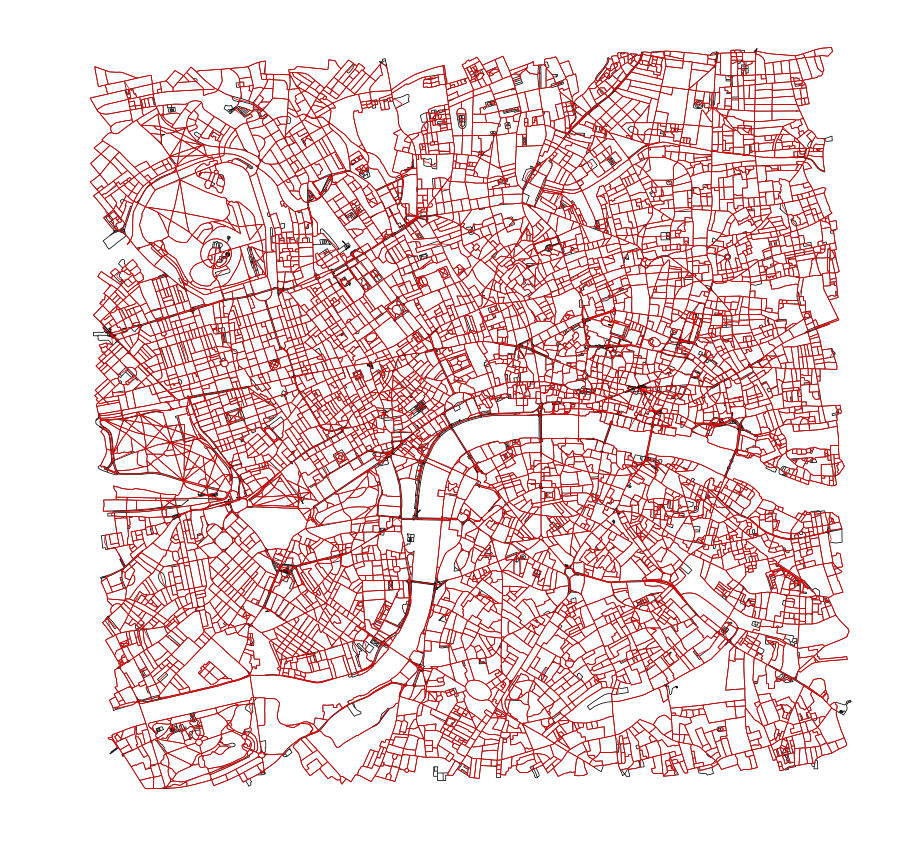

In [476]:
# plotting differences between the clean network and the simplified one
uf.plot_lines(edges_small, compare = edges_small_p)

In [545]:
# saving the simplified version of the graph
nodes_small.to_file('Outputs/tmp/'+city_name+'_nodes_PA.shp', driver='ESRI Shapefile')
edges_small[['streetID', 'geometry', 'length', 'highway', 'name', 'u', 'v']].to_file(
    'Outputs/tmp/'+city_name+'_edges_PA.shp', driver='ESRI Shapefile')

In [ ]:
%%time

# cleaning and simplifying large network as well
if Option_2 == True:
    nodes_large, edges_large = snf.reset_index_gdf(nodes_large, edges_large)
    nodes_large, edges_large = snf.simplify_network(nodes_large, edges_large, dead_ends = True)
    nodes_large_p, edges_large_p = nodes_large.copy(), edges_large.copy()
    nodes_large, junctions = snf.simplify_junctions(nodes_large, edges_large, 12)
    nodes_large, edges_large = snf.simplify_dual_lines(nodes_large, edges_large, junctions)
    nodes_large, edges_large = snf.correct_edges(nodes_large, edges_large, junctions)
    nodes_large, edges_large = snf.simplify_network(nodes_large, edges_large, dead_ends = True)
    nodes_large, edges_large, = snf.reset_index_gdf(nodes_large, edges_large)

# Indexes computation - Nodes

On the primal graph representation of the street network, the following centrality measures are computed on nodes, on the basis of Euclidean distance:
* Betweenness centrality.
* Straightness centrality (see [Crucitti et al. 2006](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.73.036125)).
* Reach centrality (readataped from [Sevtsuk & Mekonnen 2012](https://www.sutd.edu.sg/cmsresource/idc/papers/2012_Urban_Network_Analysis_A%20New%20Toolbox_for_ArcGIS.pdf)) - it measures the importance of a node based on the number of services (e.g. commercial activities) reachable by that node (for instance within a buffer).
* Local betweenness centrality (slow).

The first measure (*Bc*) is here used to identify Lynchian nodes.

In [56]:
attributes_nodes = [] # besides nodeID -- please specify nodes attributes that you want to keep in the graph representation
edges_costs = ['length'] # -- please specify edges attributes that you want to keep in the graph representation
# obtaining graph from the two geodataframes
NGs = snf.graph_fromGDF(nodes_small, edges_small, attributes_nodes, edges_costs)

## Centrality measures

In [57]:
%%time
# betweenness centrality
Bc = nx.betweenness_centrality(NGs, k = None, weight = 'length', normalized = False)

In [ ]:
%%time
# straightness centrality
# Sc = snf.straightness_centrality(NGs, weight = 'length', normalized=False)

In [61]:
%%time
# reach centrality pre-computation, in relation to Point of Interests or any other point-geodataframes 
services = (gpd.read_file(folder_ouptut+'/'+city_name+'_POI.shp')).to_crs(epsg=epsg)

# using a 50 mt buffer
NGs = snf.weight_nodes(nodes_small, services, NGs, buffer = 50)
      
# Reach Centrality
Rc400 = snf.reach_centrality(NGs, weight = 'length', radius = 400) 
Rc600 = snf.reach_centrality(NGs, weight = 'length', radius = 600)

In [63]:
%%time

# Local Betweenness Centrality
Bc600 = snf.local_betweenness_centrality(NGs, weight = 'length', radius = 400) 
Bc400 = snf.local_betweenness_centrality(NGs, weight = 'length', radius = 600)

In [196]:
# saving the attributes in a geodataframe

col = [Bc, Rc400, Rc600, Bc400, Bc600]
names = ['Bc', 'Rc400', 'Rc600', 'Bc400', 'Bc600']
nodes_df = uf.dict_to_df(col, names)
nodes = pd.merge(nodes_small, nodes_df, left_on= "nodeID", right_index = True, how = 'left')

### Saving the area of interest for external uses (e.g. simulation)

In [ ]:
# clipping and rescaling the values

buffer = polygon_clip.geometry.loc[0].buffer(100)
nodes_clipped = nodes[nodes.geometry.within(buffer)]
edges_clipped = edges[edges.geometry.within(buffer)]
nodes_clipped, edges_clipped = snf.simplify_network(nodes_clipped, edges_clipped, dead_ends = True)
nodesDual_clipped, edgesDual_clipped = snf.dual_gdf(nodes_clipped, edges_clipped, crs)

col = ['Bc', 'Rc400', 'Rc600', 'Bc400', 'Bc600']
for i in col: uf.scaling_columnDF(nodes_clipped, i)

col = ['length']
for i in col: uf.scaling_columnDF(edges_clipped, i)

col = ['deg', 'rad']
for i in col: uf.scaling_columnDF(edgesDual_clipped, i)

In [ ]:
n3, p3 = correct_edges(n,p) 

In [ ]:
# saving the clipped networks

nodes_clipped['height'] = 2 # this will be used for 3d visibility analysis
nodes_clipped.crs = crs
nodes_clipped.to_file(folder_ouptut+city_name+'_nodes.shp', driver ='ESRI Shapefile')
edges_clipped.crs = crs
edges_clipped.to_file(folder_ouptut+city_name+'_paths.shp', driver ='ESRI Shapefile')

nodesDual_clipped = nodesDual_small.drop('intersecting', axis=1)
nodesDual_clipped.crs = crs
nodesDual_clipped.to_file(folder_ouptut+city_name+'_nodesDual.shp', driver = 'ESRI Shapefile')

edgesDual_clipped.crs = crs
edgesDual_clipped.to_file(folder_ouptut+city_name+'_edgesDual.shp', driver = 'ESRI Shapefile')

# Paths

On the primal graph representation of the street network, the following centrality measures are computed on edges:
* Euclidean Betweenness centrality.
* Information Betweenness centrality.
On the dual graph representation of the street network:
* Angular Betweenness centrality.

The third measure (*Ab*) is here used to identify Lynchian paths.

In [79]:
%%time
# Euclidean betweenness centrality
Eb = nx.edge_betweenness_centrality(NGs, weight = 'length', normalized = False)

In [80]:
%%time
# Information centrality
Erw = nx.edge_current_flow_betweenness_centrality(NGs, weight= 'length', normalized=False)
# reordering elements
for k, v in Erw.items():
    if k[0] > k[1]: Erw[(k[1], k[0])] = Erw.pop((k[0], k[1]))

In [103]:
# creating geodataframe
edgesID = {}
for i, g in NGs.edges(): edgesID[(i,g)] = NGs[i][g]['streetID']

col = [Eb, Erw, edgesID]
names = ['Eb', 'Erw', 'streetID']

edges_df = uf.dict_to_df(col, names)
edges_df.streetID = edges_df.streetID.astype(int)
edges_tmp = pd.merge(edges_small, edges_df, left_on = 'streetID', right_on = 'streetID', how = 'left')

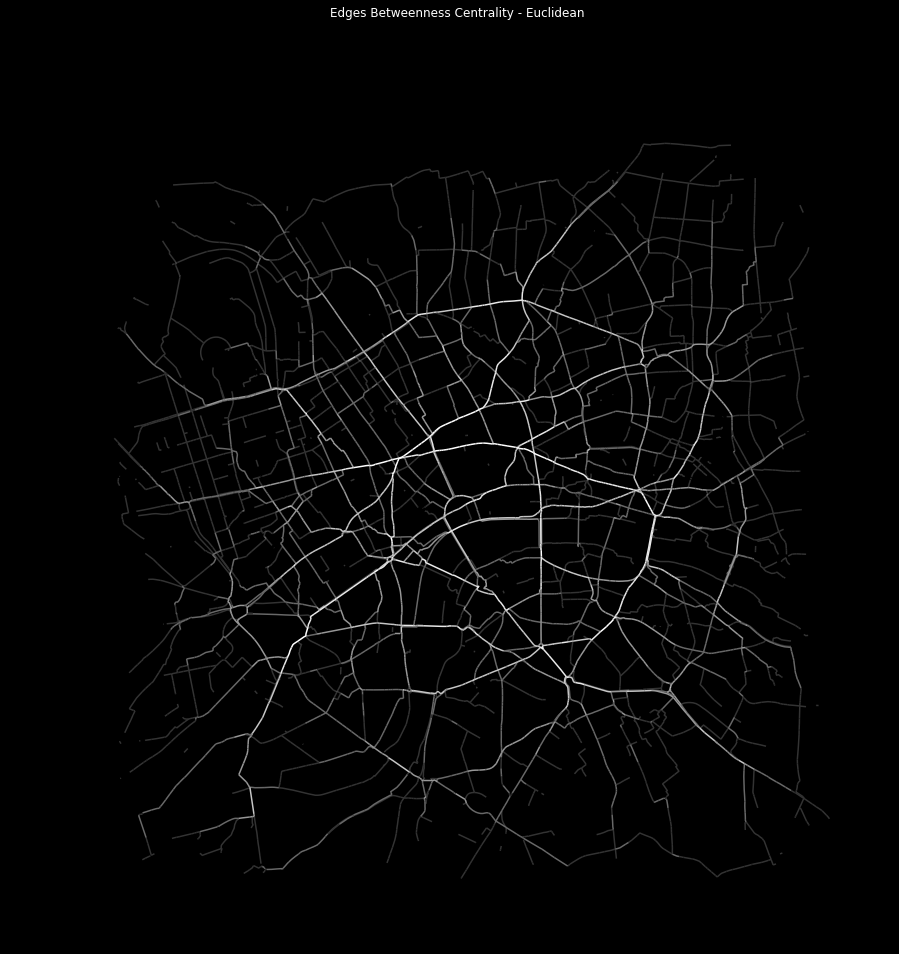

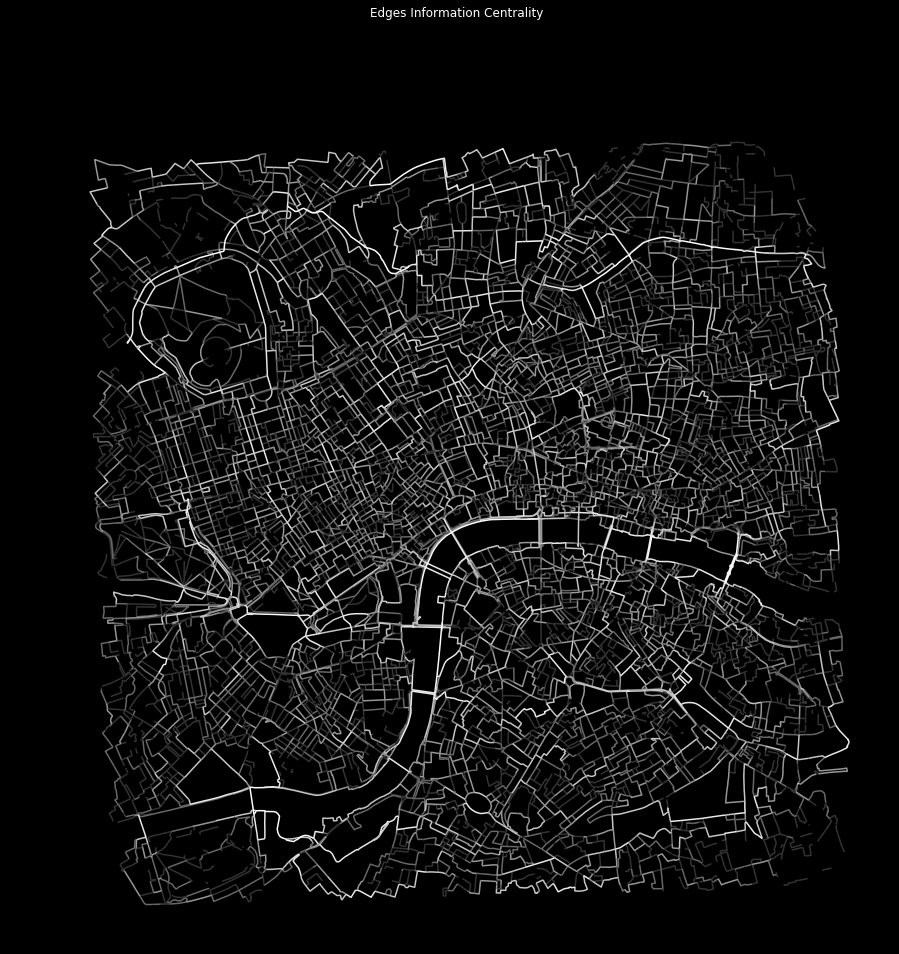

In [240]:
# visualising
uf.plot_lines(edges_tmp, classes = 7, column = 'Eb', title = 'Edges Betweenness Centrality - Euclidean', lw = 1.5,
              scheme = 'fisher_jenks', cmap = 'Greys_r', fcolor = 'black')
uf.plot_lines(edges_tmp, classes = 7, column = 'Erw', title = 'Edges Information Centrality', lw = 1.5,
              scheme = 'fisher_jenks', cmap = 'Greys_r', fcolor = 'black')

# Dual graph analysis

Here street-segments are transformed into nodes (geograpically represented by their centroids). Fictional links represent instead intersections. Thus if two segments are connected in the actual street network, a link in the dual graph representation will be created by connecting the corresponding nodes. 
This process allows to take advantage of angular relationships in centrality measures computation and other network techniques.

In [129]:
%%time
# creating the dual geodataframes. The angle of incidence is computed at this stage, between each pair of street-segments.
nodesDual_small, edgesDual_small = snf.dual_gdf(nodes_small, edges_small, crs)
# nodesDual_large, edgesDual_large = snf.dual_gdf(nodes_large, edges_large, crs)

Wall time: 44min 12s


## Creating the dual graph

In [135]:
# defining dual-edges attributes to keep and create the dual graph
# 'rad' is the angle of incidenge in radians, 'deg' in degrees
edges_costs = ['rad', 'length', 'deg']  
DG_small = snf.get_dual_graph(nodesDual_small, edgesDual_small, edges_costs)

## Angular Betweenness - Paths

In [149]:
# Angular-change betweenness centrality
Ab = nx.betweenness_centrality(DG_small, weight = 'rad', normalized = False)
Ab_dict = snf.dual_id_dict(Ab, DG_small, 'streetID')
Ab_df = uf.dict_to_df([Ab_dict], ['Ab'])
edges = pd.merge(edges_tmp, Ab_df, left_on = "streetID", right_index = True, how='left')

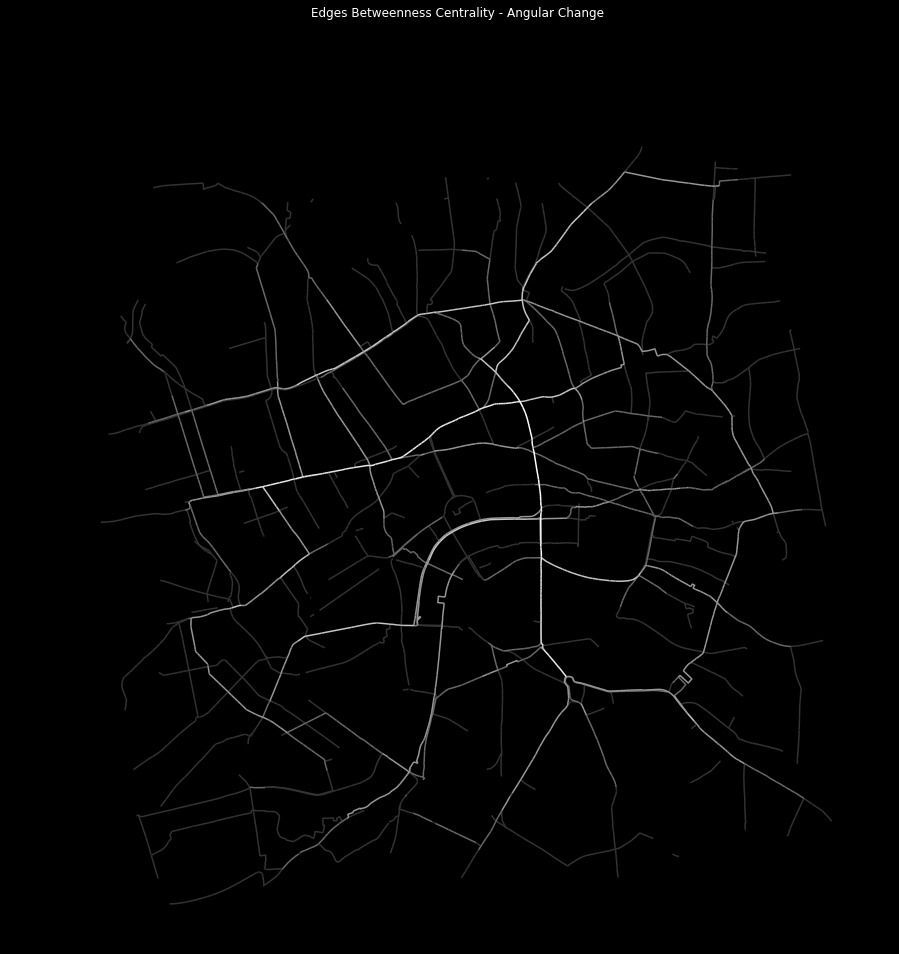

In [241]:
uf.plot_lines(edges, classes = 7, column = 'Ab', title = 'Edges Betweenness Centrality - Angular Change', lw = 1.5, 
              scheme = 'fisher_jenks', cmap = 'Greys_r', fcolor = 'black')

## Districts

Finally, districts are extracted using the Modularity Optimisation Algorithm.

In [154]:
# specify which graph shall be used for the district identification
if option_1 == True: 
    nodes_large, edges_large = nodes_small, edges_small
    DG_large = DG_small
else: DG_large =  snf.get_dual_graph(nodesDual_large, edgesDual_large)

In [157]:
# different weights are used to extract the partitions;
# 'False' indicates that no weights will be used (only topological relationships will matter)
weights = ['length', 'rad', 'False']
subdvisions = []

# extraction of the best partitions
for i in weights:
    partition = community.best_partition(DG_large, weight=i)
    dct = snf.dual_id_dict(partition, DG_large, 'streetID')
    subdvisions.append(dct)

# saving the data in a geodataframe
partitions_df = uf.dict_to_df(subdvisions, ["p_len", "p_rad", 'p_no'])
districts = pd.merge(edges_large, partitions_df, left_on = "streetID", right_index = True, how= 'left')

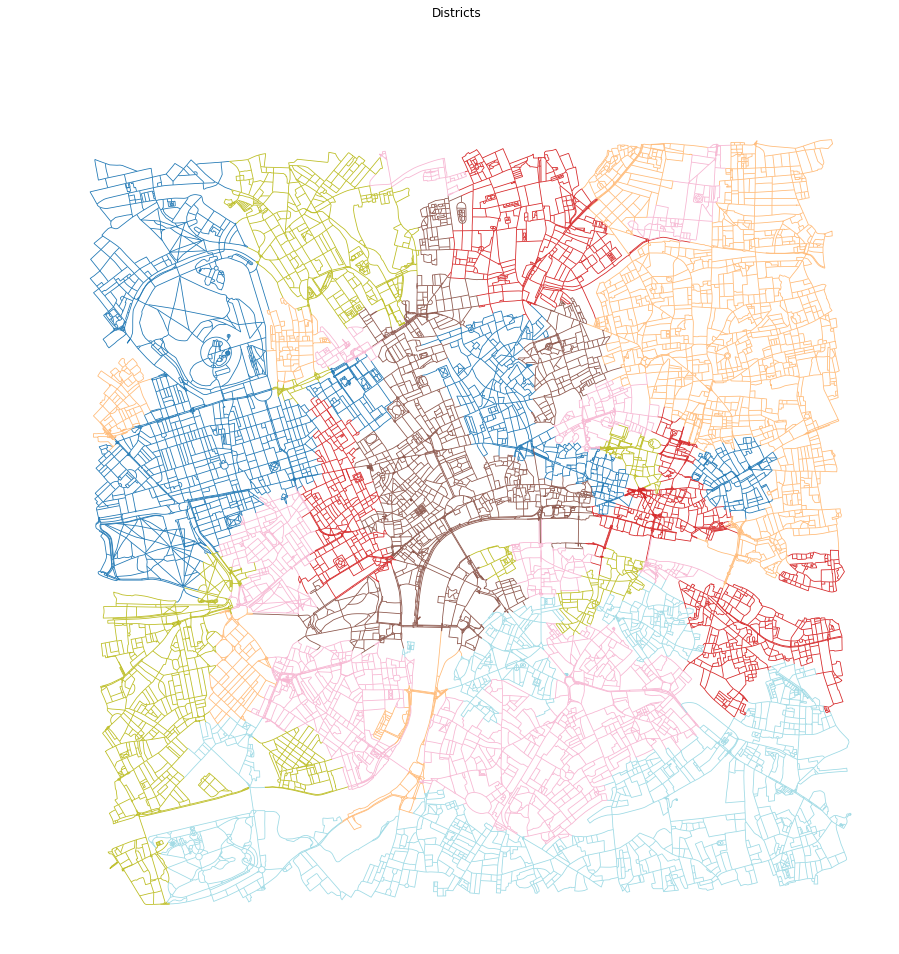

In [227]:
# visualising
uf.plot_lines(districts, column = 'p_rad', title = 'Districts', lw = 0.8, cmap = 'tab20', legend = False)

# Natural Roads

Finally, before saving, street segments are categorised based on the continuing roads or natural roads approach.
Streets are indeed recognised as entities by an observer in relation to the perception of continuity - a concept adressed already by Lynch himself - rather than for their name.
Continuity is based indeed on the degree of angular change.

In [204]:
%%time
# running natural roads_functions
edges['natural_id'] = "NA"
natural_id = 0 

for row in edges.itertuples():

    if (row[-1] != 'NA'): continue # if already assigned to a natural road
    snf.natural_roads(row[0], natural_id, "fr", nodes, edges) # assuming streetID = index
    snf.natural_roads(row[0], natural_id, "to", nodes, edges) 
    natural_id = natural_id+1

Wall time: 13min 43s


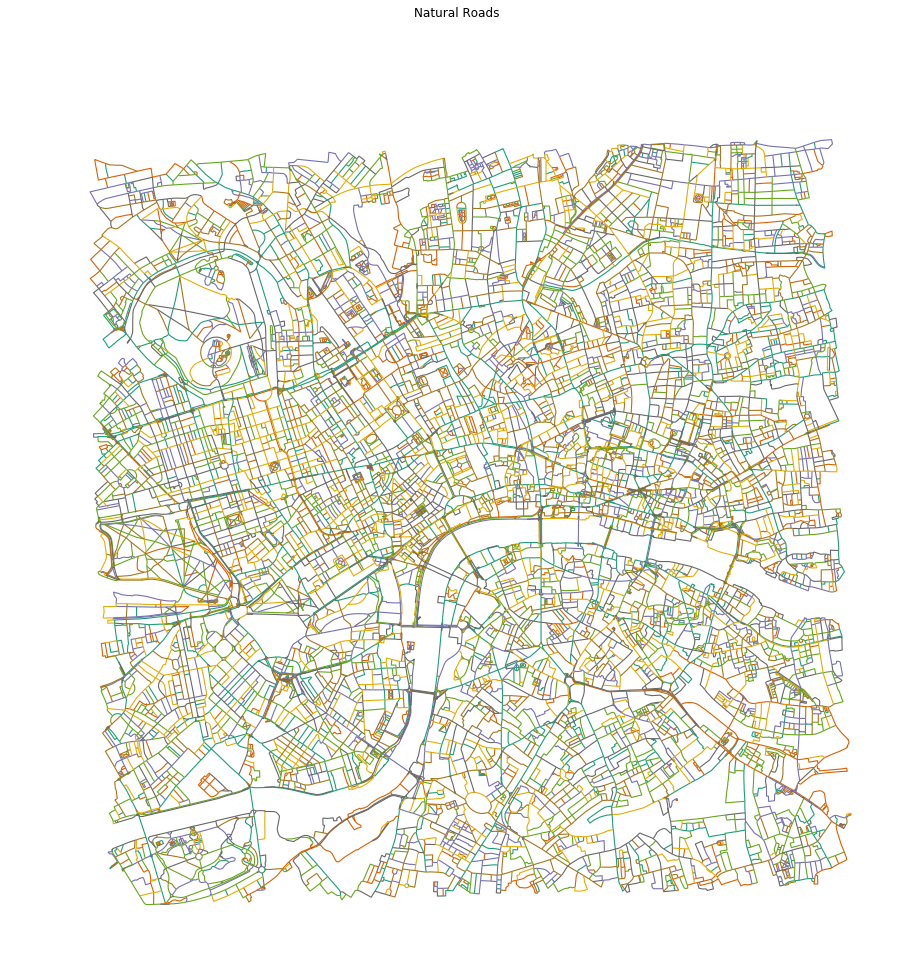

In [230]:
# visualising
uf.plot_lines(edges, column = 'natural_id', title = 'Natural Roads', lw = 1.1, cmap = 'Dark2',
              black_back = False, legend = False)

# Saving Large network

In [269]:
# saving the large networks

nodes.crs = crs
nodes.to_file(folder_ouptut+'large_network/'+city_name+'_nodes.shp', driver='ESRI Shapefile')
edges.crs = crs
edges.to_file(folder_ouptut+'large_network/'+city_name+'_paths.shp', driver ='ESRI Shapefile')

nodesDual_small = nodesDual_small.drop('intersecting', axis=1)
nodesDual_small.crs = crs
nodesDual_small.to_file(folder_ouptut+'large_network/'+city_name+'_nodesDual.shp', driver = 'ESRI Shapefile')
edgesDual_small.crs = crs
edgesDual_small.to_file(folder_ouptut+'large_network/'+city_name+'_edgesDual.shp', driver = 'ESRI Shapefile')

In [272]:
# saving districts
districts.crs = crs
districts.to_file(folder_ouptut+city_name+'_paths.shp', driver = 'ESRI Shapefile')

In [147]:
n3, p3 = correct_edges(n,p)

Correcting edges coordinates..
Done


In [146]:

def correct_edges(nodes_gdf, edges_gdf):
    
    print("Correcting edges coordinates..")
    
    index_u = edges_gdf.columns.get_loc("u")+1
    index_v = edges_gdf.columns.get_loc("v")+1 
    index_geometry = edges_gdf.columns.get_loc("geometry")+1 
    
    for row in edges_gdf.itertuples():
        u = nodes_gdf.loc[row[index_u]]['nodeID']
        v = nodes_gdf.loc[row[index_v]]['nodeID']
        line_coords = list(row[index_geometry].coords)
        line_coords[0] = (nodes_gdf.loc[u]['x'], nodes_gdf.loc[u]['y'])
        line_coords[-1] = (nodes_gdf.loc[v]['x'], nodes_gdf.loc[v]['y'])
        geo_line = (LineString([coor for coor in line_coords]))
        
        edges_gdf.set_value(row[0],"geometry", geo_line)

    print("Done") 
    return(nodes_gdf, edges_gdf)